In [1]:
# Install all python libraries required for this course.
!pip install -r requirements.txt #Expect error as have already pip installed all

In [7]:
# Import all relevent libraries to analyse the data
import pandas as pd #Data analysis library
import numpy as np #Complex scientific functions - essential for pandas and matplot
#Pandas is more high level data structures - for spreadsheets. Num
import datetime #Date time
import math #Adding math functions ie. math.sqrt(4)
import matplotlib.pyplot as plt #Graphs

# This line makes sure that our graphs are rendered within the notebook
%matplotlib inline

# Set options to display all columns
pd.set_option("display.max_columns",None)

In [17]:
# Load the data into a pandas dataframe
# Display the size of the dataset and first couple of rows to see what it looks like
data=pd.read_csv('iplayer_data_sample_janapr2017.csv', parse_dates=['start_date_time'])
print(data.shape) #Returns (Rows,Columns)
print(data.head()) #First 5 results

(490852, 8)
  user_id program_id series_id          genre programme_duration  \
0  GUNMFC    BUNBFKC    RFMHXZ        Factual           00:00:21   
1  GUNMFC    SBTKDEW    EWBFGO         Comedy           00:01:51   
2  GUNMFC    AXXRZDT    HFZOYT        Factual           00:00:30   
3  GUNMFC    WEXFFOO    HZCOOC  Entertainment           00:01:22   
4  GUNMFC    AUQGTSV    YMAXJD          Sport           00:01:37   

      streaming_id         start_date_time  time_viewed  
0  1486911129420_1 2017-02-12 15:21:24.544      20920.0  
1  1484864257965_1 2017-01-19 22:47:04.648     111285.0  
2  1487099603980_1 2017-02-14 19:42:36.667      29945.0  
3  1484773546557_1 2017-01-18 21:35:11.466      82620.0  
4  1486911176609_1 2017-02-12 15:22:08.965      97444.0  
15


In [19]:
# Enhance the data with a few additional columns
# Here we create some functions that we will apply to our dataset columns afterwards

# Get the weekday
def get_weekday(formated_time):
    return 'weekday_' + str(formated_time.weekday()) #returns "weekday_(dayofweek in  number)"

# Get the two-week number. We will forecast the minutes watched in the last two weeks
# Python3 rounds 0.5 up and down depending on the integer so we can't use round function
def get_twoweeknumber(formated_time):
    return math.floor(formated_time.isocalendar()[1]/2.0)

# Get the time of day
def get_timeofday(formated_time):
    hour=formated_time.hour
    if hour in range(5,13):
        return 'Morning'
    elif hour in range(13,18):
        return 'Afternoon'
    elif hour in range(18,23):
        return 'Evening'
    else:
        return 'Night'

# Parse the programme duration 
# and turn it into minutes so that we can compute the percentage of time watched
# we assume programme_duration is in hh:mm:ss
def parse_programme_duration(unformated_time):
    try:
        timeparts=unformated_time.split(':')
        #timeparts = [hour,minutes,seconds]
        return int(timeparts[0])*60.0+int(timeparts[1])+int(timeparts[2])/60
        #returns total minutes.
    except: #Will be used when program duration is blank
        return

In [20]:
# Apply the functions to the dataframe
data['weekday']=data['start_date_time'].apply(get_weekday) #Week day
data['time_of_day']=data['start_date_time'].apply(get_timeofday) #Time of day function
data['programme_duration_mins']=data['programme_duration'].apply(parse_programme_duration)
data['twoweek']=data['start_date_time'].apply(get_twoweeknumber) 

# Convert time viewed and length of programme into minutes
data['min_watched']=data['time_viewed']/(60000.0) #Was split seconds i believe?

data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched
0,GUNMFC,BUNBFKC,RFMHXZ,Factual,00:00:21,1486911129420_1,2017-02-12 15:21:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667
1,GUNMFC,SBTKDEW,EWBFGO,Comedy,00:01:51,1484864257965_1,2017-01-19 22:47:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750
2,GUNMFC,AXXRZDT,HFZOYT,Factual,00:00:30,1487099603980_1,2017-02-14 19:42:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083
3,GUNMFC,WEXFFOO,HZCOOC,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:35:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000
4,GUNMFC,AUQGTSV,YMAXJD,Sport,00:01:37,1486911176609_1,2017-02-12 15:22:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067


In [22]:
# Check how many missing and unique values there are per column
features=data.columns.values #Titles of each column
for feature in features: #For each feature in features
    print(feature,'- Missing:', 
          sum(data[feature].isnull()),
          '- Unique:', len(data[feature].unique())) #Prints *titlename* - Missing: *blank values* - Unique: *unique sets of data*

user_id - Missing: 0 - Unique: 9937
program_id - Missing: 33698 - Unique: 23857
series_id - Missing: 33698 - Unique: 5921
genre - Missing: 67719 - Unique: 12
programme_duration - Missing: 33698 - Unique: 891
streaming_id - Missing: 0 - Unique: 434430
start_date_time - Missing: 0 - Unique: 490626
time_viewed - Missing: 1900 - Unique: 259532
weekday - Missing: 0 - Unique: 7
time_of_day - Missing: 0 - Unique: 4
programme_duration_mins - Missing: 33698 - Unique: 891
twoweek - Missing: 0 - Unique: 10
min_watched - Missing: 1900 - Unique: 259532


In [35]:
# First create a data frame that maps each piece of content with its genre
series_mapping=pd.pivot_table(data,values='streaming_id',
                              index=['series_id'],
                              columns=['genre'],
                              aggfunc=len).idxmax(axis=1) #Creates table linking series id's and genres.
#Series_mapping = series_id
#                 AACTJC          Factual
series_mapping=pd.DataFrame(series_mapping).reset_index().rename(columns={0:'enriched_genre'}) #Adds index and genre title
#series_id enriched_genre
#0       AACTJC        Factual
series_mapping.head()


,series_id,enriched_genre
0,AACTJC,Factual
1,AADNYN,Drama
2,AAHBPO,Factual
3,AAJXRW,Factual
4,AAOAJI,Drama


In [36]:
# Let's merge in the genre back into the data
data=pd.merge(data,series_mapping,how='left',on='series_id')
data[data['genre'].isnull()].head()
data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre
0,GUNMFC,BUNBFKC,RFMHXZ,Factual,00:00:21,1486911129420_1,2017-02-12 15:21:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667,Factual
1,GUNMFC,SBTKDEW,EWBFGO,Comedy,00:01:51,1484864257965_1,2017-01-19 22:47:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750,Comedy
2,GUNMFC,AXXRZDT,HFZOYT,Factual,00:00:30,1487099603980_1,2017-02-14 19:42:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083,Factual
3,GUNMFC,WEXFFOO,HZCOOC,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:35:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000,Entertainment
4,GUNMFC,AUQGTSV,YMAXJD,Sport,00:01:37,1486911176609_1,2017-02-12 15:22:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067,Sport


In [37]:
# Check how many missing and unique values for this column
features=['genre','enriched_genre']
for feature in features:
    print(feature,'- Missing:',sum(data[feature].isnull()),
          '- Unique:', len(data[feature].unique()))

genre - Missing: 67719 - Unique: 12
enriched_genre - Missing: 43829 - Unique: 12


In [38]:
# What genre is the most popular at which time of day
genre_by_time=pd.pivot_table(data,values='streaming_id',
                             index=['time_of_day'],
                             columns=['enriched_genre'],
                             aggfunc=len).idxmax(axis=1)
genre_by_time=pd.DataFrame(genre_by_time).reset_index().rename(columns={0:'enriched_genre'})
genre_by_time

,time_of_day,enriched_genre
0,Afternoon,Factual
1,Evening,Factual
2,Morning,Factual
3,Night,Factual


In [39]:
# What genre is the most popular at which hour of day
# Rmk: we first need to build this new feature
data['hour']=data.start_date_time.apply(lambda x:x.hour)
genre_by_hour=pd.pivot_table(data,values='streaming_id',
                             index=['hour'],
                             columns=['enriched_genre'],
                             aggfunc=len).idxmax(axis=1)
genre_by_hour=pd.DataFrame(genre_by_hour).reset_index().rename(columns={0:'enriched_genre_hour'})
genre_by_hour

,hour,enriched_genre_hour
0,0,Factual
1,1,Factual
2,2,Factual
3,3,Factual
4,4,Factual
5,5,Factual
6,6,News
7,7,Factual
8,8,Factual
9,9,Factual


In [40]:
# Let's merge in the genre back into the data
data=pd.merge(data,genre_by_hour,how='left',on='hour')
data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour
0,GUNMFC,BUNBFKC,RFMHXZ,Factual,00:00:21,1486911129420_1,2017-02-12 15:21:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667,Factual,15,Factual
1,GUNMFC,SBTKDEW,EWBFGO,Comedy,00:01:51,1484864257965_1,2017-01-19 22:47:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750,Comedy,22,Drama
2,GUNMFC,AXXRZDT,HFZOYT,Factual,00:00:30,1487099603980_1,2017-02-14 19:42:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083,Factual,19,Factual
3,GUNMFC,WEXFFOO,HZCOOC,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:35:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000,Entertainment,21,Drama
4,GUNMFC,AUQGTSV,YMAXJD,Sport,00:01:37,1486911176609_1,2017-02-12 15:22:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067,Sport,15,Factual


In [41]:
# Function that imputes a genre based on the series id or the time of day if data is missing
def impute_genre(row):
    if isinstance(row['genre'],str):
        return row['genre']
    elif isinstance(row['enriched_genre'],str):
        return row['enriched_genre']
    else:
        return row['enriched_genre_hour']

In [43]:
# Apply the function to the dataframe
data['enriched_genre']=data.apply(impute_genre, axis=1)
data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour
0,GUNMFC,BUNBFKC,RFMHXZ,Factual,00:00:21,1486911129420_1,2017-02-12 15:21:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667,Factual,15,Factual
1,GUNMFC,SBTKDEW,EWBFGO,Comedy,00:01:51,1484864257965_1,2017-01-19 22:47:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750,Comedy,22,Drama
2,GUNMFC,AXXRZDT,HFZOYT,Factual,00:00:30,1487099603980_1,2017-02-14 19:42:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083,Factual,19,Factual
3,GUNMFC,WEXFFOO,HZCOOC,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:35:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000,Entertainment,21,Drama
4,GUNMFC,AUQGTSV,YMAXJD,Sport,00:01:37,1486911176609_1,2017-02-12 15:22:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067,Sport,15,Factual


In [44]:
# Check how many missing and unique values for this column
features=['genre','enriched_genre']
for feature in features:
    print(feature,'- Missing:',sum(data[feature].isnull()),
          '- Unique:', len(data[feature].unique()))

genre - Missing: 67719 - Unique: 12
enriched_genre - Missing: 0 - Unique: 11


In [45]:
# Check whether this has worked
data[data['genre'].isnull()].head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour
134,EBWVEE,CKVVVUL,PCVHKP,NaN,00:00:00,1485900618555_1,2017-01-31 22:40:20.049,3584.0,weekday_1,Evening,0.0,2,0.059733,Factual,22,Drama
140,EBWVEE,NaN,NaN,NaN,NaN,1489439401348_1,2017-03-13 21:40:02.421,3730.0,weekday_0,Evening,NaN,5,0.062167,Drama,21,Drama
141,EBWVEE,NaN,NaN,NaN,NaN,1485100892026_1,2017-01-22 16:31:34.292,3634.0,weekday_6,Afternoon,NaN,1,0.060567,Factual,16,Factual
142,EBWVEE,NaN,NaN,NaN,NaN,1489441109070_3,2017-03-13 22:08:30.203,3651.0,weekday_0,Evening,NaN,5,0.060850,Drama,22,Drama
143,EBWVEE,NaN,NaN,NaN,NaN,1493538827057_2,2017-04-30 08:23:47.559,3665.0,weekday_6,Morning,NaN,8,0.061083,Factual,8,Factual


In [46]:
# Check the average length of a programme based on genre 
# Rmk: we rename the columns for merging afterwards
length_by_genre=data.groupby('genre')['programme_duration_mins'].median()
length_by_genre=pd.DataFrame(length_by_genre).reset_index().rename(columns={'programme_duration_mins':
                                                            'enriched_duration_mins',
                                                            'genre':'enriched_genre'})
length_by_genre
#Creates table of genre and median length

genre
Children's           15.0
Comedy               28.0
Drama                45.0
Entertainment        30.0
Factual              45.0
Learning             10.0
Music                60.0
News                 30.0
Religion & Ethics    60.0
Sport                80.0
Weather              30.0
Name: programme_duration_mins, dtype: float64


,enriched_genre,enriched_duration_mins
0,Children's,15.0
1,Comedy,28.0
2,Drama,45.0
3,Entertainment,30.0
4,Factual,45.0
5,Learning,10.0
6,Music,60.0
7,News,30.0
8,Religion & Ethics,60.0
9,Sport,80.0


In [47]:
# Let's merge in the duration back into the data
data=pd.merge(data,length_by_genre,how='left',on='enriched_genre')
data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour,enriched_duration_mins
0,GUNMFC,BUNBFKC,RFMHXZ,Factual,00:00:21,1486911129420_1,2017-02-12 15:21:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667,Factual,15,Factual,45.0
1,GUNMFC,SBTKDEW,EWBFGO,Comedy,00:01:51,1484864257965_1,2017-01-19 22:47:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750,Comedy,22,Drama,28.0
2,GUNMFC,AXXRZDT,HFZOYT,Factual,00:00:30,1487099603980_1,2017-02-14 19:42:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083,Factual,19,Factual,45.0
3,GUNMFC,WEXFFOO,HZCOOC,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:35:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000,Entertainment,21,Drama,30.0
4,GUNMFC,AUQGTSV,YMAXJD,Sport,00:01:37,1486911176609_1,2017-02-12 15:22:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067,Sport,15,Factual,80.0


In [48]:
# Function that imputes a duration based on the (enriched) genre
def impute_duration(row):
    if row['programme_duration_mins']>0:
        return row['programme_duration_mins']
    else:
        return row['enriched_duration_mins']

In [49]:
# Apply the function to the dataframe
data['enriched_duration_mins'] = data.apply(impute_duration, axis=1)

In [50]:
# Check whether this has worked
data[data['programme_duration_mins'].isnull()].head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour,enriched_duration_mins
140,EBWVEE,NaN,NaN,NaN,NaN,1489439401348_1,2017-03-13 21:40:02.421,3730.0,weekday_0,Evening,NaN,5,0.062167,Drama,21,Drama,45.0
141,EBWVEE,NaN,NaN,NaN,NaN,1485100892026_1,2017-01-22 16:31:34.292,3634.0,weekday_6,Afternoon,NaN,1,0.060567,Factual,16,Factual,45.0
142,EBWVEE,NaN,NaN,NaN,NaN,1489441109070_3,2017-03-13 22:08:30.203,3651.0,weekday_0,Evening,NaN,5,0.060850,Drama,22,Drama,45.0
143,EBWVEE,NaN,NaN,NaN,NaN,1493538827057_2,2017-04-30 08:23:47.559,3665.0,weekday_6,Morning,NaN,8,0.061083,Factual,8,Factual,45.0
144,EBWVEE,NaN,NaN,NaN,NaN,1489258896796_3,2017-03-11 19:31:39.890,3545.0,weekday_5,Evening,NaN,5,0.059083,Factual,19,Factual,45.0


In [51]:
# Check how many missing and unique values for this column
features=['programme_duration_mins','enriched_duration_mins']
for feature in features:
    print(feature,'- Missing:',sum(data[feature].isnull()),
          '- Unique:', len(data[feature].unique()))

programme_duration_mins - Missing: 33698 - Unique: 891
enriched_duration_mins - Missing: 0 - Unique: 889


In [52]:
data.time_viewed.describe()

count    4.889520e+05
mean     8.565867e+05
std      3.491022e+06
min     -3.563513e+06
25%      3.935000e+03
50%      8.194150e+04
75%      9.219698e+05
max      8.515021e+08
Name: time_viewed, dtype: float64

In [53]:
# Assume that is error and make positive
data['time_viewed']=abs(data['time_viewed']) #Abs function turns positive

In [54]:
data['min_watched']=data['time_viewed']/(60000.0) #Turns into minutes
data.min_watched.describe()

count    488952.000000
mean         14.276694
std          58.183645
min           0.000000
25%           0.065583
50%           1.365700
75%          15.366200
max       14191.701283
Name: min_watched, dtype: float64

In [55]:
# Percentage of content watched by the user
data['percentage_watched']=(data['min_watched']/data['enriched_duration_mins'])
data.percentage_watched.describe()

count    488952.000000
mean          1.054973
std          17.764672
min           0.000000
25%           0.004064
50%           0.139491
75%           0.805828
max        4971.469250
Name: percentage_watched, dtype: float64

In [56]:
# Clean up the percentage field from when the number is more than 100%
def clean_perc(number):
    return min(number,1)

In [57]:
# Clean up percentaged watched from anything bigger than 100%
data['percentage_watched']=data['percentage_watched'].apply(clean_perc)

In [58]:
# Check how many missing and unique values there are per column
features=data.columns.values
for feature in features:
    print(feature,'- Missing:', 
          sum(data[feature].isnull()),
          '- Unique:', len(data[feature].unique()))

user_id - Missing: 0 - Unique: 9937
program_id - Missing: 33698 - Unique: 23857
series_id - Missing: 33698 - Unique: 5921
genre - Missing: 67719 - Unique: 12
programme_duration - Missing: 33698 - Unique: 891
streaming_id - Missing: 0 - Unique: 434430
start_date_time - Missing: 0 - Unique: 490626
time_viewed - Missing: 1900 - Unique: 259529
weekday - Missing: 0 - Unique: 7
time_of_day - Missing: 0 - Unique: 4
programme_duration_mins - Missing: 33698 - Unique: 891
twoweek - Missing: 0 - Unique: 10
min_watched - Missing: 1900 - Unique: 259529
enriched_genre - Missing: 0 - Unique: 11
hour - Missing: 0 - Unique: 24
enriched_genre_hour - Missing: 0 - Unique: 3
enriched_duration_mins - Missing: 0 - Unique: 889
percentage_watched - Missing: 1900 - Unique: 298032


In [59]:
data.head()

,user_id,program_id,series_id,genre,programme_duration,streaming_id,start_date_time,time_viewed,weekday,time_of_day,programme_duration_mins,twoweek,min_watched,enriched_genre,hour,enriched_genre_hour,enriched_duration_mins,percentage_watched
0,GUNMFC,BUNBFKC,RFMHXZ,Factual,00:00:21,1486911129420_1,2017-02-12 15:21:24.544,20920.0,weekday_6,Afternoon,0.350000,3,0.348667,Factual,15,Factual,0.350000,0.996190
1,GUNMFC,SBTKDEW,EWBFGO,Comedy,00:01:51,1484864257965_1,2017-01-19 22:47:04.648,111285.0,weekday_3,Evening,1.850000,1,1.854750,Comedy,22,Drama,1.850000,1.000000
2,GUNMFC,AXXRZDT,HFZOYT,Factual,00:00:30,1487099603980_1,2017-02-14 19:42:36.667,29945.0,weekday_1,Evening,0.500000,3,0.499083,Factual,19,Factual,0.500000,0.998167
3,GUNMFC,WEXFFOO,HZCOOC,Entertainment,00:01:22,1484773546557_1,2017-01-18 21:35:11.466,82620.0,weekday_2,Evening,1.366667,1,1.377000,Entertainment,21,Drama,1.366667,1.000000
4,GUNMFC,AUQGTSV,YMAXJD,Sport,00:01:37,1486911176609_1,2017-02-12 15:22:08.965,97444.0,weekday_6,Afternoon,1.616667,3,1.624067,Sport,15,Factual,1.616667,1.000000


In [60]:
# Drop the 1st of January - incomplete week
data=data[data['start_date_time']>'2017-01-02']

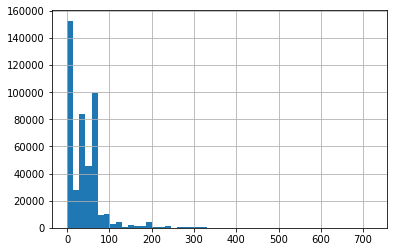

In [61]:
# Check the distribution of our numerical values
#Programme Duration
data['programme_duration_mins'].hist(bins=50) #Creates histogram
#Long tailed. More that last 60 mins than 30 mins.

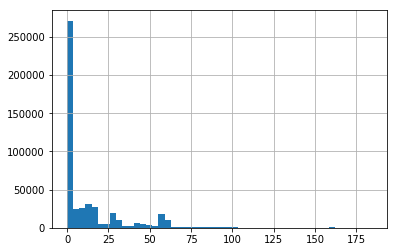

In [62]:
# Check the distribution for length watches (under 200 mins to be able to see more)
#Minutes watched (those less than 200 mins)
data[data['min_watched']<200]['min_watched'].hist(bins=50)
#Surprisingly high number that only watch for 1 min. Not only 1 min shows but those that quickly turn off.

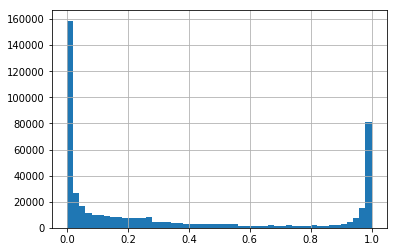

In [63]:
# Check the distribution of the completion rate
data['percentage_watched'].hist(bins=50) #Roughly 32% first bar (2%). Only 16% complete.

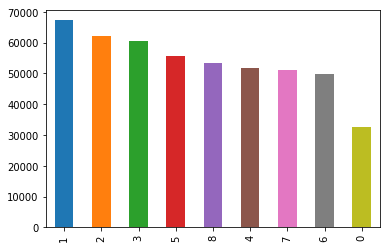

In [64]:
# Check whether we have more or less the same amount of data for each two week period. Form of validating representative sample.
data['twoweek'].value_counts().plot(kind='bar')

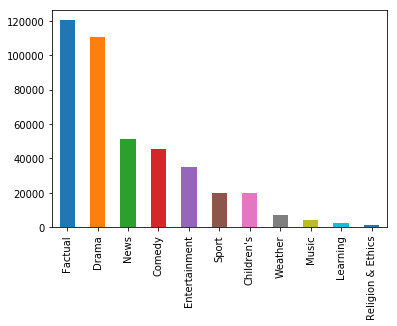

In [75]:
# Check distribution of categorical values
data['genre'].value_counts().plot(kind='bar') #Shows how many shows are shows of each genre not popularity.
#Not solid evidence but suggests factual and drama are most popular. Better way may be to show viewcount by genre.
#Graph would be data.groupby(['genre'])['min_watched'].sum().plot(kind='bar')

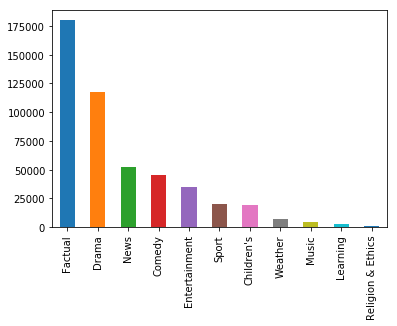

In [67]:
# How does this differ from the distribution of the enriched genre?
# For NULL values - for 21 hours of the day assumptions were made that factual was genre. Because we assumed this, there is a big
# Increase in factual genre. Drama and news have stayed very similar- but the assumptions forgot about the smaller genres.
data['enriched_genre'].value_counts().plot(kind='bar')

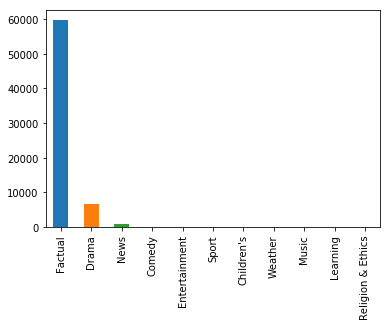

In [68]:
# Plot the difference between the genre and enriched genre.
diff = data['enriched_genre'].value_counts() - data['genre'].value_counts() 
diff.plot(kind='bar')

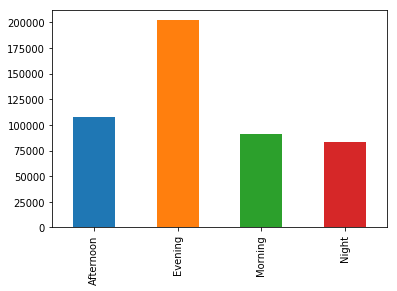

In [69]:
# When do people mostly watch (distribution over time of day)?
data['time_of_day'].value_counts().sort_index().plot(kind='bar')

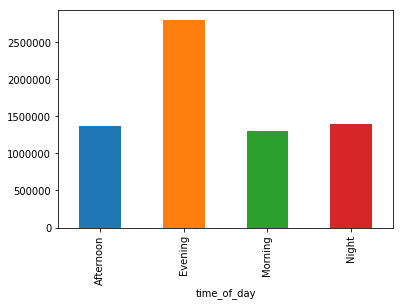

In [70]:
data.groupby(['time_of_day'])['min_watched'].sum().plot(kind='bar')

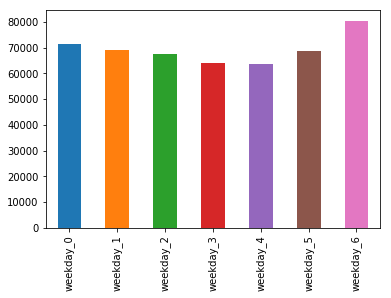

In [71]:
# Distribution over the weekday (weekday_0 is Monday)
data['weekday'].value_counts().sort_index().plot(kind='bar')

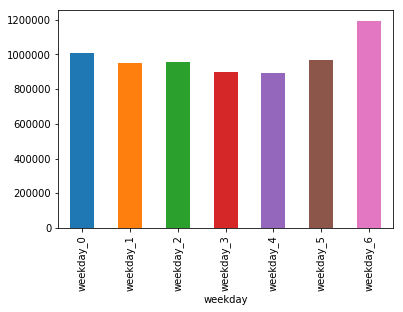

In [72]:
data.groupby(['weekday'])['min_watched'].sum().plot(kind='bar')

Evening      28868.000000
Afternoon    15376.285714
Morning      13034.571429
Night        11976.571429
Name: time_of_day, dtype: float64

*********** 

weekday_0



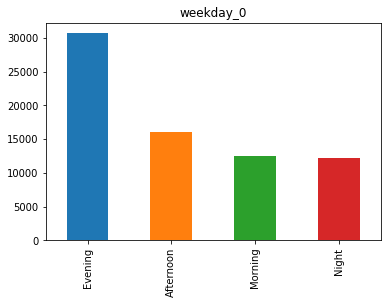

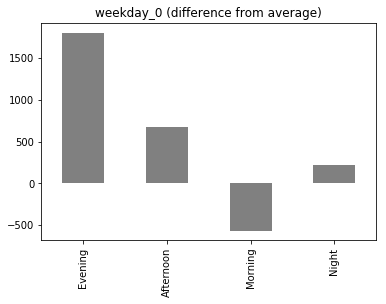


*********** 

weekday_1



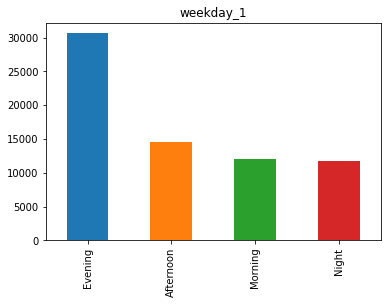

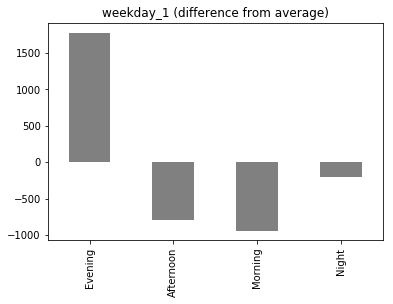


*********** 

weekday_2



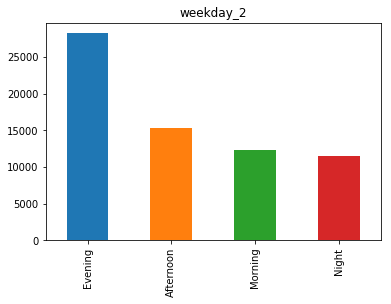

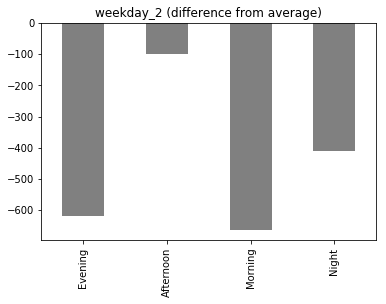


*********** 

weekday_3



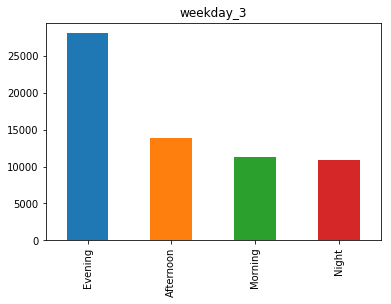

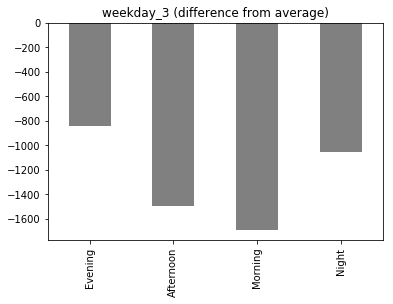


*********** 

weekday_4



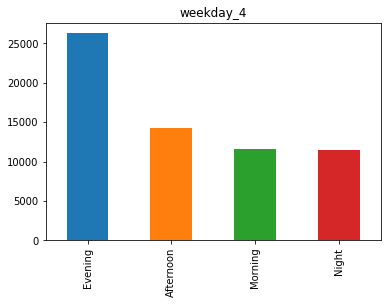

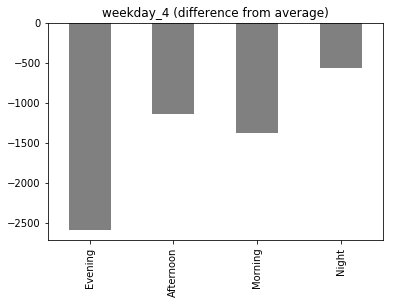


*********** 

weekday_5



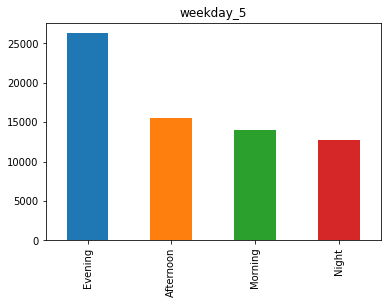

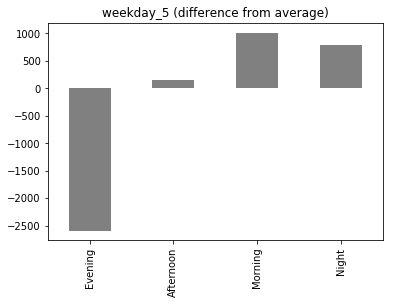


*********** 

weekday_6



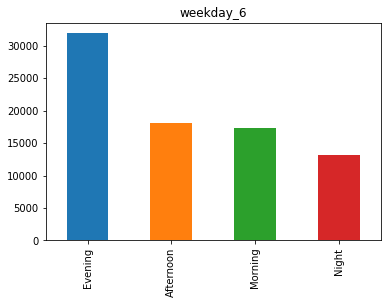

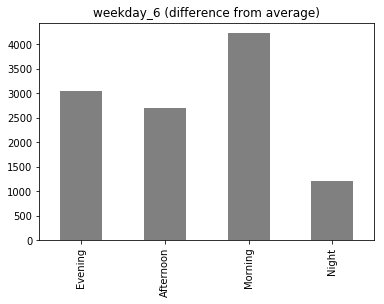

In [76]:
# Let's look at whether people watch at different times across different days

averageCounts=data['time_of_day'].value_counts()/7 #Returns average for times of day.
#For each day - shows graph of views for different times of the day. Then 2nd graph shows how it differs from the average.
for day in sorted(set(data['weekday'])):   
    print('\n*********** \n')
    print(day+'\n')
    
    data[data['weekday']==day]['time_of_day'].value_counts().plot(kind='bar')
    plt.title(day)
    plt.show()
    
    diff=data[data['weekday']==day]['time_of_day'].value_counts() - averageCounts
    diff.plot(kind='bar',color='grey')
    plt.title(day+" (difference from average)")
    plt.show()

In [77]:
# Get the number of unique users in the dataset
print('Number of users: '+
      str(len(data.user_id.unique())))

Number of users: 9794


In [78]:
# We first need to aggregate the number of observations per user per twoweek
# Describe gives us some basic statistics on this new field
data.groupby(['user_id','twoweek']).size().describe()

count    39834.000000
mean        12.170206
std         20.698870
min          1.000000
25%          2.000000
50%          5.000000
75%         14.000000
max        495.000000
dtype: float64

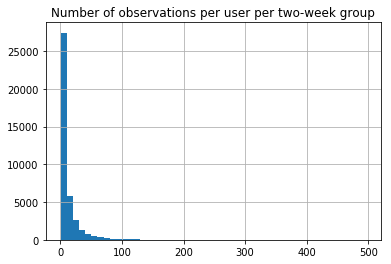

In [79]:
data.groupby(['user_id','twoweek']).size().hist(bins=50)
plt.title('Number of observations per user per two-week group')
plt.show()
#Most saw 0-10 minutes in the two week group.

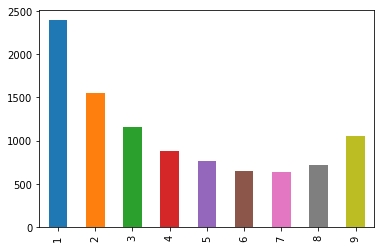

In [83]:
# We first need to get all the possible pairs user_id x twoweek
# And then aggregate at the user id level
nb_twoweeks_user=data[['user_id','twoweek']].drop_duplicates()
nb_twoweeks_user=pd.DataFrame(nb_twoweeks_user.groupby(['user_id']).size())
nb_twoweeks_user=nb_twoweeks_user.rename(columns={0:'nb_twoweek'})
nb_twoweeks_user.nb_twoweek.value_counts().sort_index().plot(kind='bar')

In [107]:
# We want to get the number of users that come back from one two-week group to another
# We first create a table of 0 and 1s 
# if a given user (row) consumes content on a given two-week (column)
twoweeks_user=data[['user_id','twoweek']].drop_duplicates().set_index('user_id')
twoweeks_user.twoweek=twoweeks_user.twoweek.apply(lambda x:str(x))
twoweeks_user=pd.get_dummies(twoweeks_user).reset_index().groupby(['user_id']).sum()
twoweeks_user.head()

,twoweek_0,twoweek_1,twoweek_2,twoweek_3,twoweek_4,twoweek_5,twoweek_6,twoweek_7,twoweek_8
user_id,,,,,,,,,
AADDJF,0,0,1,1,0,0,0,0,0
AADVCF,1,1,1,1,1,1,1,1,0
AADWBM,0,1,1,0,0,0,0,0,0
AAHITE,0,1,1,1,1,1,1,1,1
AAKIJG,0,1,0,0,0,0,0,0,0


In [108]:
# Let's build a retention matrix
ret_matrix=pd.DataFrame(columns=np.arange(0,9), index=np.arange(0,9))

for i in np.arange(0,8):
    # We fill [i,i] with the number of users consuming content in twoweek i
    ret_matrix.loc[i,i]=sum(twoweeks_user['twoweek_'+str(i)])
    twoweeks_user.cumul_tmp=twoweeks_user['twoweek_'+str(i)]
    
    for j in np.arange(i+1,9):
        # Then we fill for the other columns of row i [i,j] the number of users consuming
        # content in every twoweek from twoweek i to twoweek j
        twoweeks_user.cumul_tmp+=twoweeks_user['twoweek_'+str(j)]
        ret_matrix.loc[i,j]=len(twoweeks_user[twoweeks_user.cumul_tmp==j+1-i])
        
ret_matrix.loc[8,8]=sum(twoweeks_user['twoweek_'+str(8)])
ret_matrix

c:\users\gillro~1\docume~1\datala~1\virtua~1\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


,0,1,2,3,4,5,6,7,8
0,4374,2872,2161,1827,1560,1412,1264,1137,1051
1,NaN,6705,3635,2769,2232,1931,1673,1474,1354
2,NaN,NaN,5491,3471,2634,2204,1866,1614,1468
3,NaN,NaN,NaN,4376,3060,2479,2051,1739,1562
4,NaN,NaN,NaN,NaN,4002,2927,2309,1892,1681
5,NaN,NaN,NaN,NaN,NaN,4008,2799,2163,1874
6,NaN,NaN,NaN,NaN,NaN,NaN,3705,2525,2103
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3417,2547
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3756


In [109]:
# Let's put these results in ratios of the size of the cohorts
ret_matrix_ratio=pd.DataFrame(columns=np.arange(0,9), index=np.arange(0,9))
for i in np.arange(0,9):
    for j in np.arange(0,9):
        ret_matrix_ratio.loc[i,j]=ret_matrix.loc[i,j]/ret_matrix.loc[i,i]
ret_matrix_ratio
#Shows retention chances - in group 0 - 65% chance of coming back etc.(see row 1)

,0,1,2,3,4,5,6,7,8
0,1,0.656607,0.494056,0.417695,0.356653,0.322817,0.28898,0.259945,0.240283
1,NaN,1,0.542133,0.412975,0.332886,0.287994,0.249515,0.219836,0.201939
2,NaN,NaN,1,0.632125,0.479694,0.401384,0.339829,0.293936,0.267347
3,NaN,NaN,NaN,1,0.699269,0.566499,0.468693,0.397395,0.356947
4,NaN,NaN,NaN,NaN,1,0.731384,0.576962,0.472764,0.42004
5,NaN,NaN,NaN,NaN,NaN,1,0.698353,0.539671,0.467565
6,NaN,NaN,NaN,NaN,NaN,NaN,1,0.681511,0.567611
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.745391
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [110]:
# Let's compute an average retention ratio
ret_tw=[]
for i in np.arange(0,8):
    ret_tw+=[ret_matrix_ratio.loc[i,i+1]] '#Gives average value from (0,1),(1,2) etc.
print('Average retention from one twoweek to another: '+str(np.mean(ret_tw)))

Average retention from one twoweek to another: 0.673346720203


In [111]:
data.to_csv('iplayer_data_c1.csv', index=False)